In [1]:
############################################################
import os, re
from glob              import glob
from scipy.optimize    import curve_fit, fsolve, root
from scipy.interpolate import interp1d, interp2d, interpn
from scipy.special     import erf
from scipy.integrate   import odeint, solve_ivp
from collections       import OrderedDict
from configparser      import ConfigParser

%reload_ext autoreload
%autoreload 1
from   pylab         import *

import matplotlib
%matplotlib inline

matplotlib.rcParams[ 'font.size'        ] = 14;
matplotlib.rcParams[ 'font.family'      ] = 'serif';
matplotlib.rcParams[ 'text.usetex'      ] = True;
matplotlib.rcParams[ 'axes.labelsize'   ] = 16;
matplotlib.rcParams[ 'legend.fontsize'  ] = 14;
matplotlib.rcParams[ 'legend.edgecolor' ] = 'k';
matplotlib.rcParams[ 'figure.facecolor' ] = 'w';
matplotlib.rcParams[ 'figure.facecolor' ] = 'w';


h      = 6.62607e-27;   # CGS Planctk constant
kb     = 1.38065e-16;   # CGS Boltzmann constant
eV     = 1.60218e-12;   # CGS eV
c      = 2.99792458e10; # CGS speed of light
e_c    = 4.80321e-10;   # CGS electron charge
me     = 9.1094e-28;    # CGS electron mass;
mp     = 1.67262e-24;   # CGS proton mass;
AU     = 1.49598e13     # Astronomical Unit in cm
yr     = 3.1536e7       # 1 yr in sec
G      = 6.6740831e-8   # CGS graviational constant
sig_sb = 5.6704e-5      # Stefan-Boltzmann

modot  = 2e33;
mearth = 6e27
rearth = 6.4e8;
lodot  = 3.828e33; 
yr     = 365. * 86400.;


# species = [ 'Vacant', r'H$_2$', r'H$_2$O', 'CO' ];
# colors  = [ plt.cm.tab20( i ) for i in [ 14, 18, 19, 2 ] ];

species = [ 'Vacant', r'H$_2$O', 'CO' ];
colors  = [ plt.cm.tab20( i ) for i in [ 14, 19, 2 ] ];
cmap    = mpl.colors.ListedColormap( colors );
############################################################

In [2]:
class disk_model:
    def __init__( self, sigma_1 = 600, sig_idx   = -1.5, \
                  T_1 = 280, T_idx = -0.4, gamma =  1.4, \
                  mu  = 2 * mp, M_star = modot ):
        self.sigma_1 = sigma_1;
        self.sig_idx = sig_idx;
        self.T_1     =     T_1;
        self.T_idx   =   T_idx;
        self.gamma   =   gamma;
        self.mu      =      mu;
        self.M_star  =  M_star;
    #
    def T( self, r ):
        return self.T_1 * ( r / AU )**self.T_idx;
    #    
    def Omega( self, r ):
        return sqrt( G * self.M_star / r**3 );
    #
    def cs( self, r ):
        return sqrt( self.gamma * kb * self.T( r ) / self.mu );
    #
    def h( self, r ):
        return self.cs( r ) / self.Omega( r );
    #
    def sigma( self, r ):
        return self.sigma_1 * ( r / AU )**self.sig_idx;
    #
    def n_0  ( self, r ):
        return self.sigma( r ) / sqrt( 2 * pi ) \
             / self.h( r ) / mp;
    #
#

def f_msT_trans( n, mu, T ):
    ''' -sT in F '''
    lam2 = h**2 / ( 2 * pi * mu * kb * T );
    # res  = log( cbrt( n ) * sqrt( lam2 ) );    
    # l0   = minimum( 1e-4, cbrt( n )**-1 )
    l0   = 1e-5
    res  = log( l0**-1 * sqrt( lam2 ) );    
    return res * kb * T;
#
def f_osci( nu, T ):
    kbT  = kb * T;
    hv   = h * nu;
    return kbT * log( 1 - exp( -hv / kbT ) ) + hv / 2;
#

def de_perp( nu, T ):
    kbT  = kb * T;
    hv   = h * nu;
    return hv * ( 0.5 + 1. / ( exp( hv / kbT ) - 1 ) ) \
         - 0.5 * kbT;
#

In [40]:
4 * 4 / 64**2

0.00390625

In [56]:
tgt = '/home/lilew/kiaagpu/scratch/ads_emu/graphite/'
par_src = 'pars/c.par';

species_gen = [ 'H2O', 'CO' ];
mu_atm  = [ 18, 28 ];
abund   = [ 1.4e-4, 1.8e-4 ];

dd = disk_model(  );

sig_0 = 1e-15;

R_arr = [ 1, 3, 5, 7, 7.5, 8, 9, 10 ]
R_arr = concatenate\
    ( ( R_arr, arange( 11, 25, 1 ) ) );
R_arr = concatenate( ( R_arr, [ 30, 50, 100, 150, 200 ] ) );

# R_arr = linspace( 0.1, 1.0, 9 )
# R_arr = concatenate( ( R_arr, [ 2, 3, 5, 200 ] ) );
# R_arr = [ 0.1, 200 ];
os.system( 'rm pars/test_*.par' );
for i, r_au in enumerate( R_arr ):
    r   = r_au * AU;
    T   = dd.T  ( r );
    n0  = dd.n_0( r );

    par = ConfigParser(  );
    par.read( par_src );
    res = par;

    for sp, mu_a, ab in zip( species_gen, mu_atm, abund ):
        nu_ads = float( res[ sp ][ 'nu_ads' ] );
        nu_hop = float( res[ sp ][ 'nu_hop' ] );
        de_ads = de_perp( nu_ads, T );
        de_hop = f_osci ( nu_hop, T );
        de_tra = 2 * f_msT_trans( ab * n0, mu_a * mp, T );
        e_ads  = float( par[ sp ][ 'e_ads' ] ) - de_ads / eV
        e_ngbr = -de_hop / eV + array\
            ( [ float( a ) for a in \
                      par[ sp ][ 'e_ngbr' ].split(  ) ] );
        e_ngbr[ e_ngbr < 0 ] = 0;
        res[ sp ][ 'e_ngbr' ] = ' '.join\
            ( [ ( '%g' % a ) for a in e_ngbr ] );
        res[ sp ][ 'e_ads'  ] = '%g' %  e_ads;
        res[ sp ][ 'e_corr' ] = '%g' % ( -de_tra / eV ); 
        res[ sp ][ 'abund'  ] = '%g' % ab;
    res[ 'adsorption' ][ 'beta_inv' ]\
        = '%g' % ( kb * T / eV );
    zeta = sum( abund ) * n0 * sqrt\
        ( kb * T / ( mu_a * mp ) ) * sig_0;
    res[ 'adsorption' ][ 'zeta_in'  ] = '%g' % zeta;

    res[ 'mesh' ][ 'idx_gpu' ] = '%d' % ( i % 2 )
    print( res[ 'mesh' ][ 'idx_gpu' ] )
    # print( r_au, T, zeta )

    with open( '%s/test_%06.1f.par' % \
              ( tgt, r_au ), 'w' ) as f:
        res.write( f );
    #
#

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0


rm: cannot remove 'pars/test_*.par': No such file or directory


In [5]:
886 * 10**-0.5

280.1778006909184

In [1208]:
# os.system( 'rm *.dat; rm *.png; ./ads_emu test.par' );
t    = [  ]
data = [  ];
for file_name in glob( 'test_*.dat' ):
    t.append( float( file_name[ 5 : -4 ] ) );
    data.append( loadtxt( file_name ) );
#
i_arg = argsort ( t );
t     = array   ( t )[ i_arg ];
data  = array( data )[ i_arg ];

# cmap = cm.get_cmap( 'gnuplot', 5 );

to_plot = True;
x_sp = [  ];
for i, t_s in enumerate( t ):
    a      = data[ i ];
    n_tot  = prod( a.shape );
    x_sp_s = [  ];
    for j, sp in enumerate( species ):
        x_sp_s.append( sum( a == j ) / n_tot );
    x_sp.append( x_sp_s );
    
    if not to_plot:
        continue;
    
    fig = figure( 0 );
    ax = fig.add_subplot( 111 );
    pcm  = ax.pcolormesh( a, vmin = -0.5, vmax = 2.5, cmap = cmap );
    cbar = colorbar( pcm, ticks = arange( 3 ) );
    cbar.ax.set_yticklabels( species );
    ax.set_aspect( 1 );
    ax.text( 0, a.shape [ 1 ] * 1.05, \
             r'Step = %d' % int( t_s ) );
    fig.savefig( 'test_%04d.png' % i );
    close( fig );
#
x_sp = array( x_sp );

In [44]:
colors

[array([0.3, 0.3]),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0)]

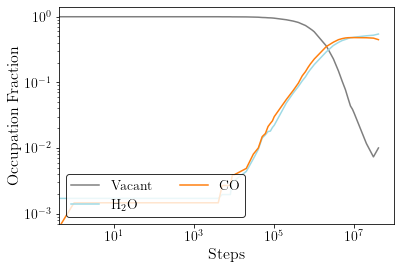

In [1209]:
for x, label, color in zip( x_sp.T, species, colors ):
    plot( t, x, color = color, label = label );
legend( ncol = 2, loc = 'lower left' );
yscale( 'log' );
xscale( 'log' );
# ylim( 1e-3, 1.2e0 );
# xlim( 1e1, None );
xlabel( 'Steps' );
ylabel( 'Occupation Fraction' );

In [15]:
tgt

'/home/lilew/ram_scratch/ads_emu/graphite/'

/home/lilew/kiaagpu/scratch/ads_emu/graphite/R_0008.0/test_9.5e+06.dat
Vacant	0.00976562
H$_2$O	0.990234
CO	0


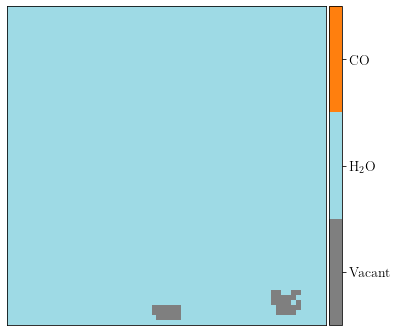

In [19]:
# os.system( './ads_emu test.par' );
# a      = loadtxt( 'test.dat' );

t = [  ]
d = 8;
files = glob( '/home/lilew/kiaagpu/scratch/ads_emu'
              '/graphite/R_%06.1f/test_*.dat' % d );

# files = glob( '%s/R_0008.0/test*.dat' % tgt );
for file_name in files:
    t.append( float( file_name.split( '/' )[ -1 ][ 5 : -4 ] ) );
#
print( files[ argmax( t ) ] )
a = loadtxt( files[ argmax( t ) ] );

n_tot  = prod( a.shape );
for j, sp in enumerate( species ):
    print( '%s\t%g' % ( sp, sum( a == j ) / n_tot ) );

fig = figure( 0, figsize = ( 6, 6 ) );
ax = fig.add_subplot( 111 );
pcm  = ax.pcolormesh( a, vmin = -0.5, vmax = 2.5, cmap = cmap,\
                     rasterized = True);


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes\
( "right", size = "4%", pad = 0.05 )
   
cbar = colorbar( pcm, ticks = arange( 3 ), cax = cax );
cbar.ax.set_yticklabels( species );
ax.set_aspect( 1 );
ax.set_yticklabels( [  ] );
ax.set_xticklabels( [  ] );
ax.tick_params( axis = 'both', which = 'both', length = 0 )
# ax.text( 0, 65, r'$R = %0.2f\ {\rm AU}$' % d  );
savefig( '../raw/surface_coverage/R_%0.2f.svg' % d );

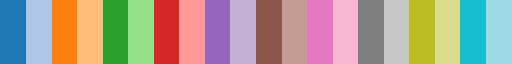

In [46]:
plt.cm.tab20

In [9]:
R_res = [  ];
f_res = [  ];

dirs = glob( '/home/lilew/kiaagpu/scratch/ads_emu/silicate/010/R_*' );
for d in dirs:
    t     = [  ]
    files = glob( d + '/test*.dat' );
    for file_name in files:
        t.append( float( file_name.split( '/' )[ -1 ][ 5 : -4 ] ) );
    a = loadtxt( files[ argmax( t ) ] );
    n_tot  = prod( a.shape );
    f_res.append( [ sum( a == j ) / n_tot \
                    for  j in range( len( species ) ) ] );
    R_res.append( float( d.split( '/' )[ -1 ].split( '_' )[ -1 ] ) );
#
i_srt = argsort( R_res );
f_res_si_010 = array( f_res )[ i_srt ];
R_res_si_010 = array( R_res )[ i_srt ];

R_res = [  ];
f_res = [  ];
dirs = glob( '/home/lilew/kiaagpu/scratch/ads_emu/silicate/001/R_*' );
for d in dirs:
    t     = [  ]
    files = glob( d + '/test*.dat' );
    for file_name in files:
        t.append( float( file_name.split( '/' )[ -1 ][ 5 : -4 ] ) );
    a = loadtxt( files[ argmax( t ) ] );
    n_tot  = prod( a.shape );
    f_res.append( [ sum( a == j ) / n_tot \
                    for  j in range( len( species ) ) ] );
    R_res.append( float( d.split( '/' )[ -1 ].split( '_' )[ -1 ] ) );
#
i_srt = argsort( R_res );
f_res_si_001 = array( f_res )[ i_srt ];
R_res_si_001 = array( R_res )[ i_srt ];

R_res = [  ];
f_res = [  ];

dirs = glob( '/home/lilew/kiaagpu/scratch/ads_emu/graphite/R_*' );
for d in dirs:
    t     = [  ]
    files = glob( d + '/test*.dat' );
    for file_name in files:
        t.append( float( file_name.split( '/' )[ -1 ][ 5 : -4 ] ) );
    a = loadtxt( files[ argmax( t ) ] );
    n_tot  = prod( a.shape );
    f_res.append( [ sum( a == j ) / n_tot \
                    for  j in range( len( species ) ) ] );
    R_res.append( float( d.split( '/' )[ -1 ].split( '_' )[ -1 ] ) );
#
i_srt = argsort( R_res );
f_res_c = array( f_res )[ i_srt ];
R_res_c = array( R_res )[ i_srt ];

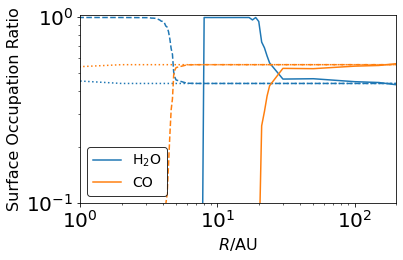

In [6]:
figure( 0, figsize = ( 6, 4 ) )
colors = [ 'k', 'tab:blue', 'tab:orange' ];
for i, sp in enumerate( species ):
    if i == 0:
        continue;
    plot( R_res_c,  f_res_c .T[ i ], \
          color = colors[ i ], label = sp );
    plot( R_res_si_010, f_res_si_010.T[ i ], \
          color = colors[ i ], linestyle = ':' );
    plot( R_res_si_001, f_res_si_001.T[ i ], \
          color = colors[ i ], linestyle = '--' );    
xscale( 'log' );
yscale( 'log' );

ylim( 1e-1, 1.02e0 );
xlim( 1e0, 200 );
legend( loc = 'lower left' );
xlabel( r'$R/{\rm AU}$' );
ylabel( 'Surface Occupation Ratio' );
tight_layout(  );
#savefig( '../raw/surf；ace_coverage/surface_fraction.svg' );
#savefig( '../surface_fraction.pdf' )

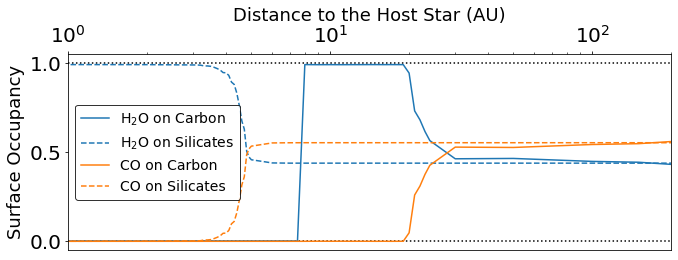

In [17]:

matplotlib.rcParams[ 'font.size'        ] = 20;
matplotlib.rcParams[ 'font.family'      ] = 'sans-serif';
matplotlib.rcParams[ 'text.usetex'      ] = False;

fig = figure( 0, figsize = ( 10, 4 ) )

axhline( 0, linestyle = ':', color = 'k' );
axhline( 1, linestyle = ':', color = 'k' );

colors = [ 'k', 'tab:blue', 'tab:orange' ];
for i, sp in enumerate( species ):
    if i == 0:
        continue;
    plot( R_res_c,  f_res_c .T[ i ], \
          color = colors[ i ], label = sp + ' on Carbon' );
#     plot( R_res_si_010, f_res_si_010.T[ i ], \
#           color = colors[ i ], linestyle = ':' );
    plot( R_res_si_001, f_res_si_001.T[ i ], \
          color = colors[ i ], linestyle = '--', \
          label = sp + ' on Silicates ');    
fig.gca(  ).xaxis.set_label_position( 'top' )
fig.gca(  ).xaxis.set_ticks_position( 'top' )
xscale( 'log' );
# yscale( 'log' );
# ylim( 1e-1, 1.1e0 );
ylim( -0.05, 1.05 )
xlim( 1e0, 200 );
legend( loc = 'center left' );
xlabel( r'Distance to the Host Star (AU)', fontsize = 18 );
ylabel( 'Surface Occupancy', fontsize = 18 );

# plot( fig.gca(  ).get_xlim(  ), zeros( 2 ), 'k--' );
# plot( fig.gca(  ).get_xlim(  ), ones ( 2 ), 'k--' );

tight_layout(  );
savefig( '../raw/schematic/surface_coverage.svg' )
#savefig( '../surface_fraction.pdf' )